In [37]:
import pandas as pd
import sql
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [48]:
data = pd.read_csv('Walmart_Sales.csv')

In [49]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [6]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [7]:
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [17]:
data.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [23]:
data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [50]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')

## Connecting to Postgresql

In [30]:
db_params = {
    'dbname': 'pranaypathole',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': 5432
}

In [31]:
conn = psycopg2.connect(**db_params)
cur = conn.cursor()

In [32]:
conn

<connection object at 0x11e573b50; dsn: 'user=postgres password=xxx dbname=pranaypathole host=localhost port=5432', closed: 0>

In [33]:
cur

<cursor object at 0x10a47d990; closed: 0>

In [34]:
create_table_query = """
    CREATE TABLE IF NOT EXISTS walmart_sales (
    store INTEGER,
    date DATE,
    weekly_sales FLOAT,
    holiday_flag INTEGER,
    temprature FLOAT,
    fuel_price FLOAT,
    cpi FLOAT,
    unemployment FLOAT
    )
"""

cur.execute(create_table_query)
conn.commit()

In [35]:
for index, row in data.iterrows():
    insert_query = """
    INSERT INTO walmart_sales (store, date, weekly_sales, holiday_flag, temprature, fuel_price, cpi, unemployment) 
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
"""

    cur.execute(insert_query, (
        row['Store'],
        row['Date'],
        row['Weekly_Sales'],
        row['Holiday_Flag'],
        row['Temperature'],
        row['Fuel_Price'],
        row['CPI'],
        row['Unemployment']
    ))

conn.commit()

cur.close()
conn.close()

## Visualizations

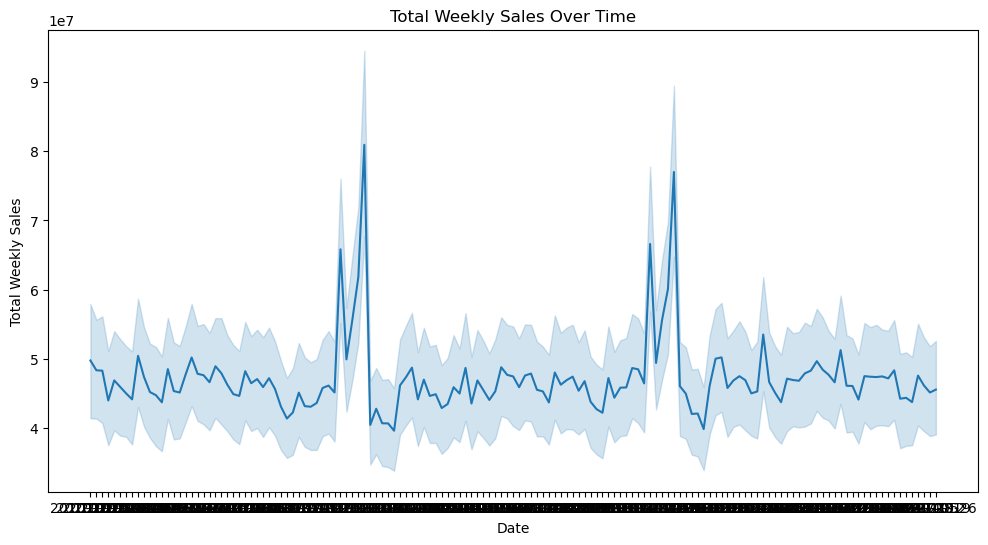

In [39]:
# Overall Sales Trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Weekly_Sales', estimator='sum')
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()

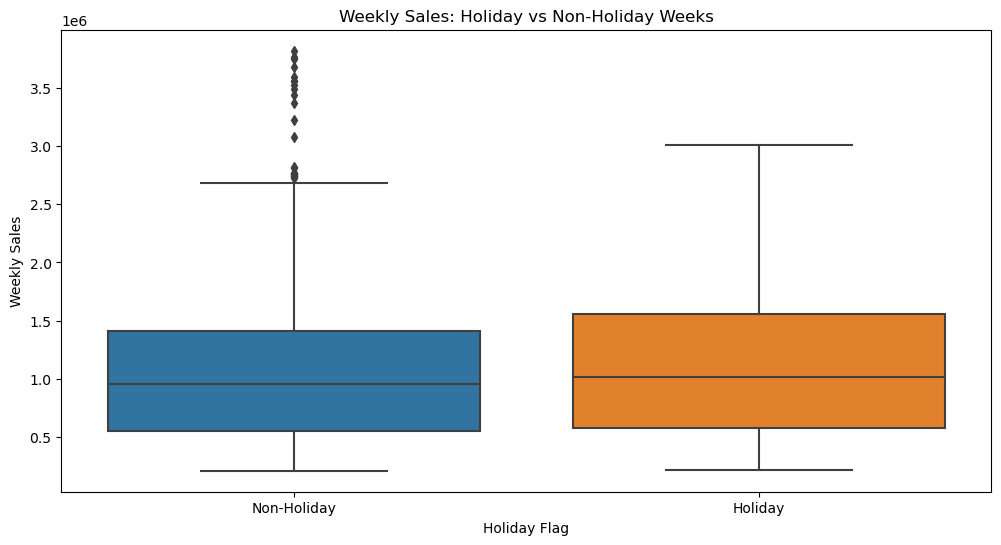

In [40]:
# Average Sales During Holiday and Non-Holiday Weeks
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Holiday_Flag', y='Weekly_Sales')
plt.title('Weekly Sales: Holiday vs Non-Holiday Weeks')
plt.xlabel('Holiday Flag')
plt.ylabel('Weekly Sales')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

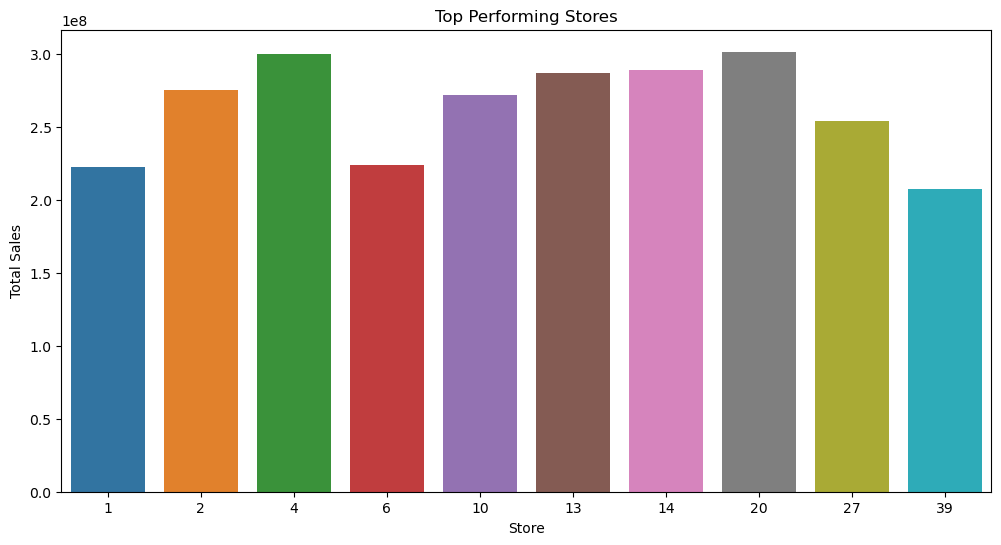

In [41]:
# Top Performing Stores
top_stores = data.groupby('Store')['Weekly_Sales'].sum().reset_index().sort_values(by='Weekly_Sales', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_stores, x='Store', y='Weekly_Sales')
plt.title('Top Performing Stores')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.show()

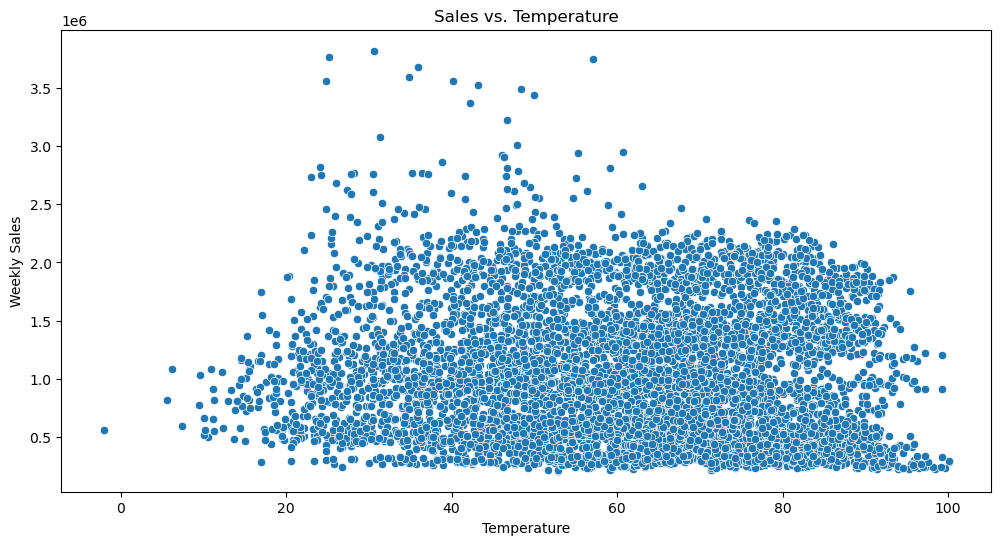

In [42]:
# Sales vs. Temperature
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='Temperature', y='Weekly_Sales')
plt.title('Sales vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.show()

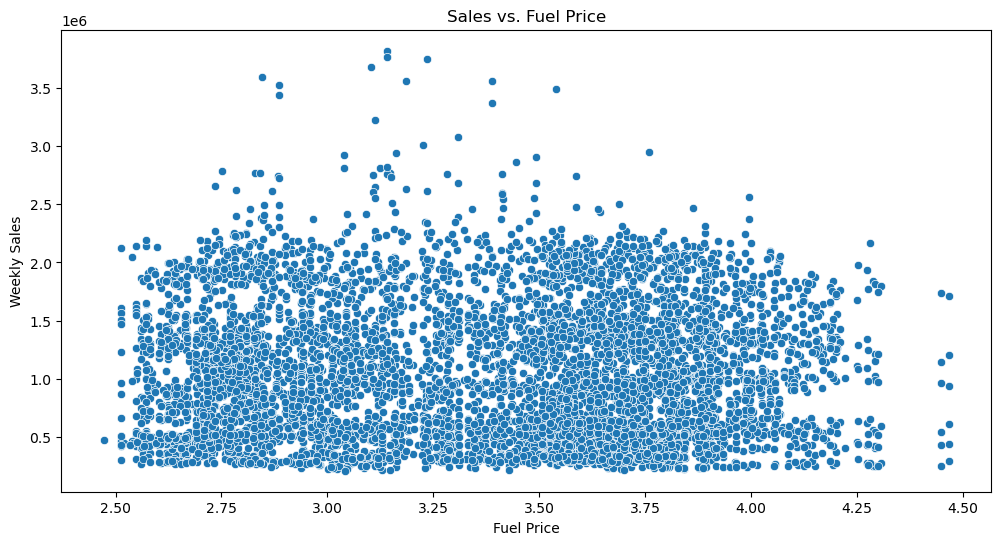

In [43]:
# Sales vs. Fuel Price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='Fuel_Price', y='Weekly_Sales')
plt.title('Sales vs. Fuel Price')
plt.xlabel('Fuel Price')
plt.ylabel('Weekly Sales')
plt.show()

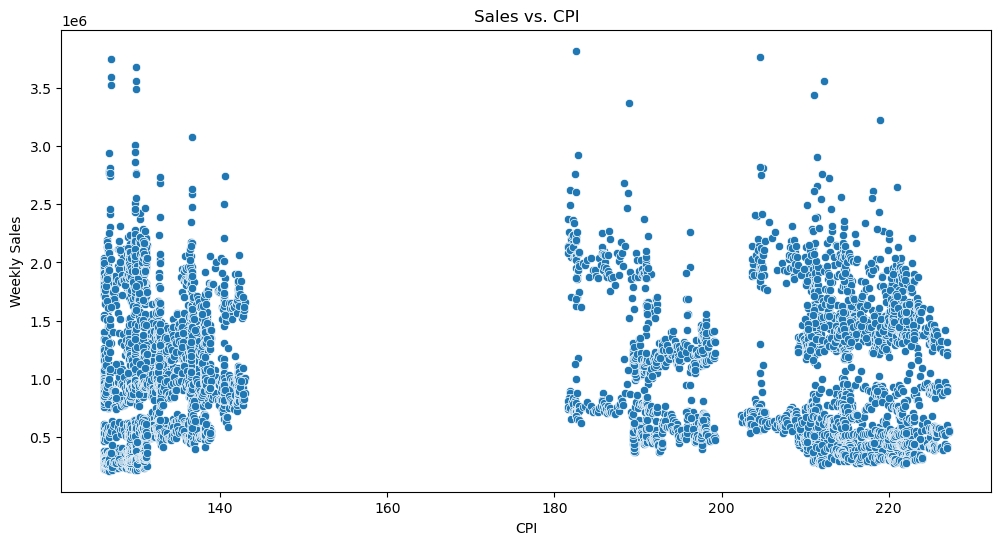

In [44]:
# Sales vs. CPI
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='CPI', y='Weekly_Sales')
plt.title('Sales vs. CPI')
plt.xlabel('CPI')
plt.ylabel('Weekly Sales')
plt.show()

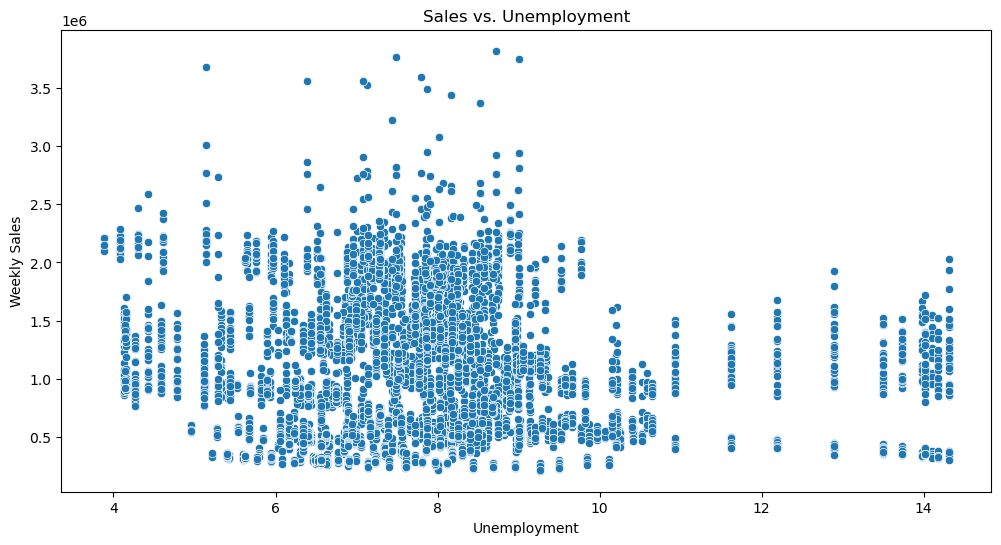

In [45]:
# Sales vs. Unemployment
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='Unemployment', y='Weekly_Sales')
plt.title('Sales vs. Unemployment')
plt.xlabel('Unemployment')
plt.ylabel('Weekly Sales')
plt.show()

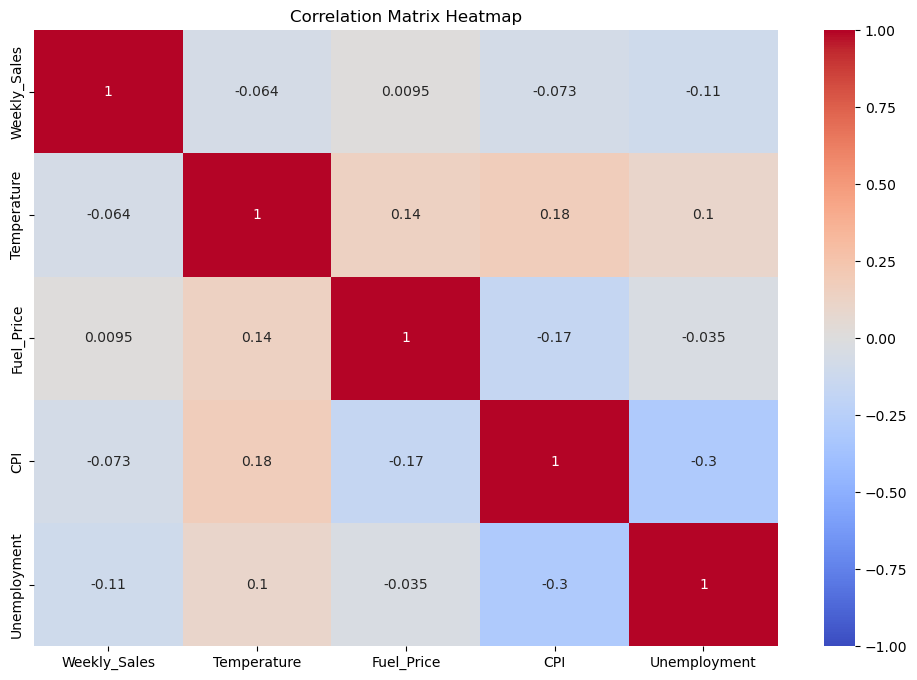

In [52]:
# Correlation Matrix Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

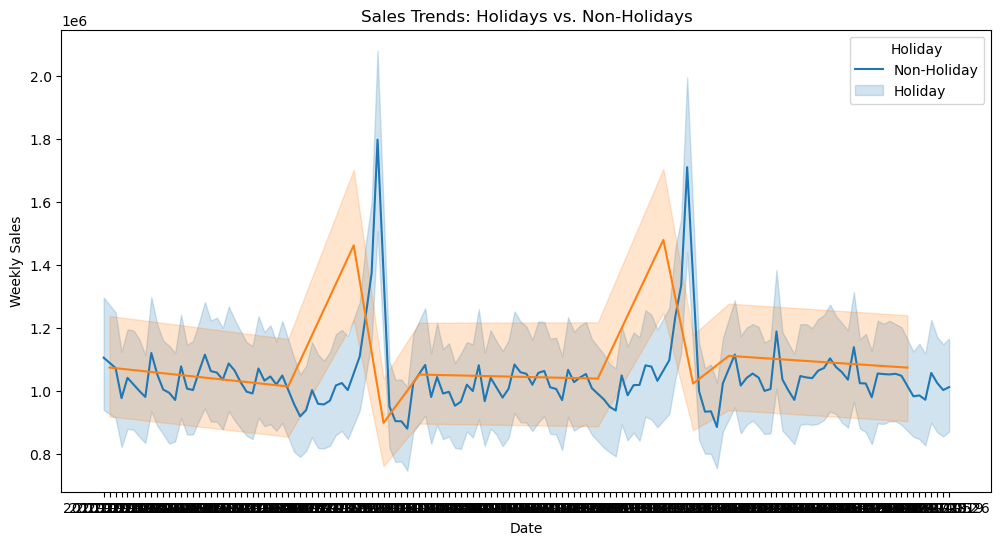

In [53]:
# Sales Trends on Holidays vs. Non-Holidays
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Weekly_Sales', hue='Holiday_Flag', palette='tab10')
plt.title('Sales Trends: Holidays vs. Non-Holidays')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(title='Holiday', labels=['Non-Holiday', 'Holiday'])
plt.show()